In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import keras
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = np.asarray(df[name], dtype = np.float).mean()

    if sd is None:
        sd = np.asarray(df[name], dtype = np.float).std()

    df[name] = (np.asarray(df[name], dtype = np.float) - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

In [4]:

# This file is a CSV, just no CSV extension or headers

df_ = pd.read_csv("./train_70%_v3.csv")
df_test = pd.read_csv("./test_30%_v3.csv")
print("Read df_ {} rows.".format(len(df_)))
print("Read df_test {} rows.".format(len(df_test)))
#print("Read {} rows.".format(len(df1)))
# df = df.sample(frac=0.1, replace=False) # Uncomment this line to sample only 10% of the dataset
df_ = df_.drop([df_.columns[0], df_.columns[8], df_.columns[9], df_.columns[10]], axis=1)
df_test = df_test.drop([df_test.columns[0], df_test.columns[8], df_test.columns[9], df_test.columns[10]], axis=1)

df_.dropna(inplace=True,axis=1) # For now, just drop NA's (rows with missing values)
df_test.dropna(inplace=True,axis=1)

Read df_ 3492 rows.
Read df_test 1497 rows.


In [5]:
df_.head(5)

,avg(pkt_len),stddev(pkt_len),fb_ratio,inter_arrival_time,pkt_count,duration,is_tcp,outcome
0,83.000000,28.867513,0.537037,133.080407,4,399.241220,0,voip
1,195.933333,371.472834,0.271744,0.018597,15,0.260353,1,voip
2,1310.382500,115.900593,-1.000000,0.002226,800,1.778840,1,streaming
3,64.000000,33.941125,2.200000,0.025113,2,0.025113,1,voip
4,205.357143,383.630352,0.279484,0.061708,14,0.802204,1,voip


In [11]:
df_test.head(5)

,avg(pkt_len),stddev(pkt_len),fb_ratio,inter_arrival_time,pkt_count,duration,is_tcp,outcome
0,316.384615,455.087075,0.751331,0.018904,26,0.472603,1,game
1,347.591837,480.886028,0.359840,0.181995,49,8.735755,1,streaming
2,73.200000,20.571825,1.859375,0.017474,5,0.069894,1,download
3,415.550000,584.567989,0.100503,0.016808,20,0.319353,1,download
4,1303.050995,129.033503,-1.000000,0.002615,804,2.099729,1,streaming


In [13]:
encode_numeric_zscore(df_, 'fb_ratio')
encode_numeric_zscore(df_, 'pkt_count')
encode_numeric_zscore(df_, 'inter_arrival_time')
encode_numeric_zscore(df_, 'stddev(pkt_len)')
encode_numeric_zscore(df_, 'avg(pkt_len)')
# encode_numeric_zscore(df_, 'pkt_len')
encode_numeric_zscore(df_, 'duration')
encode_text_index(df_, 'outcome')

encode_numeric_zscore(df_test, 'fb_ratio')
encode_numeric_zscore(df_test, 'pkt_count')
encode_numeric_zscore(df_test, 'inter_arrival_time')
encode_numeric_zscore(df_test, 'stddev(pkt_len)')
encode_numeric_zscore(df_test, 'avg(pkt_len)')
# encode_numeric_zscore(df_test, 'pkt_len')
encode_numeric_zscore(df_test, 'duration')
encode_text_index(df_test, 'outcome')

array(['download', 'game', 'streaming', 'voip'], dtype=object)

In [14]:
x_train, y_train = to_xy(df_, 'outcome')
x_test, y_test = to_xy(df_test, 'outcome')
# x, y = to_xy(df_, ' Label')

In [16]:
df_.head(5)

,avg(pkt_len),stddev(pkt_len),fb_ratio,inter_arrival_time,pkt_count,duration,is_tcp,outcome
0,-0.752548,-1.172816,0.117636,3.971602,-0.315017,2.746229,0,3
1,-0.478117,0.520962,0.026430,-0.081796,-0.303750,-0.191508,1,3
2,2.230023,-0.742540,-0.410789,-0.082295,0.500312,-0.180327,1,2
3,-0.798719,-1.147733,0.689354,-0.081598,-0.317066,-0.193240,1,3
4,-0.455217,0.581067,0.029091,-0.080483,-0.304775,-0.187518,1,3


In [17]:
import keras.backend as K
K.clear_session()

In [18]:
# Create neural net
model = Sequential()

model.add(Dense(16, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(y_train.shape[1],activation='sigmoid'))

In [19]:
# Print the model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                128       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 68        
Total params: 196
Trainable params: 196
Non-trainable params: 0
_________________________________________________________________


In [20]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        # TODO:  Create two empty lists, self.loss and self.val_acc
        self.losses = []
        self.accs = []
        self.val_acc = []
        self.val_loss = []
    def on_batch_end(self, batch, logs={}):
        # TODO:  This is called at the end of each batch.  
        # Add the loss in logs.get('loss') to the loss list
        loss = logs.get('loss')
        acc = logs.get('acc')
        self.losses.append(loss)
        self.accs.append(acc)
    def on_epoch_end(self, epoch, logs):
        # TODO:  This is called at the end of each epoch.  
        # Add the test accuracy in logs.get('loss') to the val_acc list
        val_acc = logs.get('val_acc')
        val_loss = logs.get('val_loss')
        self.val_acc.append(val_acc)
        self.val_loss.append(val_loss)

# Create an instance of the history callback
history_cb = LossHistory()

In [21]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
batch_size = 10
epochs = 300
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[history_cb],verbose=1, epochs=epochs)

Train on 3492 samples, validate on 1497 samples
Epoch 1/300
3492/3492 [==============================] - 0s - loss: 1.2613 - acc: 0.6973 - val_loss: 1.0837 - val_acc: 0.7395
Epoch 2/300
3492/3492 [==============================] - 0s - loss: 0.9843 - acc: 0.7159 - val_loss: 0.8646 - val_acc: 0.7388
Epoch 3/300
3492/3492 [==============================] - 0s - loss: 0.8913 - acc: 0.7162 - val_loss: 0.8169 - val_acc: 0.7388
Epoch 4/300
3492/3492 [==============================] - 0s - loss: 0.8502 - acc: 0.7162 - val_loss: 0.7870 - val_acc: 0.7388
Epoch 5/300
3492/3492 [==============================] - 0s - loss: 0.8218 - acc: 0.7162 - val_loss: 0.7739 - val_acc: 0.7381
Epoch 6/300
3492/3492 [==============================] - 0s - loss: 0.8033 - acc: 0.7188 - val_loss: 0.7607 - val_acc: 0.7388
Epoch 7/300
3492/3492 [==============================] - 0s - loss: 0.7903 - acc: 0.7168 - val_loss: 0.7568 - val_acc: 0.7428
Epoch 8/300
3492/3492 [==============================] - 0s - loss: 0.

3492/3492 [==============================] - 0s - loss: 0.5815 - acc: 0.7806 - val_loss: 0.8793 - val_acc: 0.7622
Epoch 130/300
3492/3492 [==============================] - 0s - loss: 0.5822 - acc: 0.7801 - val_loss: 0.8740 - val_acc: 0.7602
Epoch 131/300
3492/3492 [==============================] - 0s - loss: 0.5818 - acc: 0.7815 - val_loss: 0.8790 - val_acc: 0.7615
Epoch 132/300
3492/3492 [==============================] - 0s - loss: 0.5809 - acc: 0.7821 - val_loss: 0.8914 - val_acc: 0.7609
Epoch 133/300
3492/3492 [==============================] - 0s - loss: 0.5805 - acc: 0.7818 - val_loss: 0.8880 - val_acc: 0.7609
Epoch 134/300
3492/3492 [==============================] - 0s - loss: 0.5805 - acc: 0.7838 - val_loss: 0.8979 - val_acc: 0.7595
Epoch 135/300
3492/3492 [==============================] - 0s - loss: 0.5794 - acc: 0.7818 - val_loss: 0.8983 - val_acc: 0.7602
Epoch 136/300
3492/3492 [==============================] - 0s - loss: 0.5798 - acc: 0.7818 - val_loss: 0.8967 - val_ac

3492/3492 [==============================] - 0s - loss: 0.5490 - acc: 0.7881 - val_loss: 1.1438 - val_acc: 0.7629
Epoch 258/300
3492/3492 [==============================] - 0s - loss: 0.5491 - acc: 0.7918 - val_loss: 1.1453 - val_acc: 0.7635
Epoch 259/300
3492/3492 [==============================] - 0s - loss: 0.5484 - acc: 0.7901 - val_loss: 1.1820 - val_acc: 0.7602
Epoch 260/300
3492/3492 [==============================] - 0s - loss: 0.5491 - acc: 0.7875 - val_loss: 1.1567 - val_acc: 0.7622
Epoch 261/300
3492/3492 [==============================] - 0s - loss: 0.5486 - acc: 0.7892 - val_loss: 1.1512 - val_acc: 0.7635
Epoch 262/300
3492/3492 [==============================] - 0s - loss: 0.5478 - acc: 0.7907 - val_loss: 1.1650 - val_acc: 0.7609
Epoch 263/300
3492/3492 [==============================] - 0s - loss: 0.5476 - acc: 0.7872 - val_loss: 1.1724 - val_acc: 0.7622
Epoch 264/300
3492/3492 [==============================] - 0s - loss: 0.5479 - acc: 0.7895 - val_loss: 1.1664 - val_ac

In [22]:
# Measure accuracy
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_eval = np.argmax(y_test,axis=1)
score = metrics.accuracy_score(y_eval, pred)
print("Validation score: {}".format(score))

Validation score: 0.7621910487641951


In [23]:
from sklearn.metrics import classification_report,confusion_matrix
Cm = confusion_matrix(y_eval,pred)
C = np.sum(Cm)
Cm = Cm/C
print('Confusion Matrix:')
print(np.array_str(Cm, precision=4, suppress_small=True))

Confusion Matrix:
[[ 0.0882  0.0033  0.      0.0494]
 [ 0.0047  0.0187  0.0127  0.0782]
 [ 0.0274  0.0053  0.0227  0.0354]
 [ 0.0013  0.004   0.016   0.6326]]


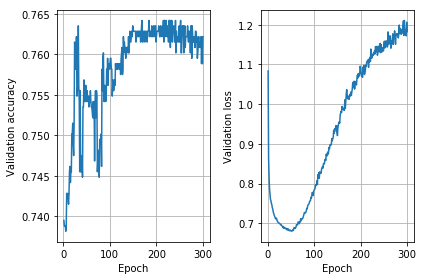

In [24]:
valAcc = history_cb.val_acc
valLoss = history_cb.val_loss
epoch_it = np.arange(1,301)
plt.subplot(121)
plt.plot(epoch_it, valAcc)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.tight_layout()
plt.subplot(122)
plt.plot(epoch_it, valLoss)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Validation loss')
plt.tight_layout()
plt.show()

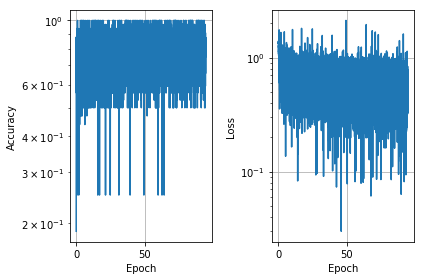

In [26]:
Ls = history_cb.losses
Acc = history_cb.accs
ntr = np.shape(x_train)[0]
epochNum = []
for i in range(33000):
    epochNum.append(i*10/ntr)

plt.subplot(121)
matplotlib.pyplot.semilogy(epochNum, Acc)
# plt.plot(epochNum, Acc)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()

plt.subplot(122)
matplotlib.pyplot.semilogy(epochNum, Ls)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
# plt.show()

# plt.axis([0.3,3,0.96,1])
plt.show()

In [27]:
# print(Cm[0])
nd = [None]*4
for i,nd in enumerate (Cm):
    for j in range (len(nd)):
        
        print(i,j,"%0.2f"%(nd[j]/np.sum(nd)))
    print("---")

0 0 0.63
0 1 0.02
0 2 0.00
0 3 0.35
---
1 0 0.04
1 1 0.16
1 2 0.11
1 3 0.68
---
2 0 0.30
2 1 0.06
2 2 0.25
2 3 0.39
---
3 0 0.00
3 1 0.01
3 2 0.02
3 3 0.97
---
